## TrafficLabelling Dataset — EDA
We now perform a dedicated EDA on the `TrafficLabelling` CSV files. The steps include: loading and combining CSVs, overview (rows/cols/dtypes), missing values, class balance, protocol/port/IP summaries, numeric distributions, correlation heatmap, pairplot, and time-series analysis if timestamps exist. Plots are saved to disk as PNGs.

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style='whitegrid')
DATA_DIR = 'TrafficLabelling'
files = sorted(glob.glob(os.path.join(DATA_DIR, '*.csv')))
print(f'Found {len(files)} CSV files in {DATA_DIR}:')
for f in files:
    print(' -', os.path.basename(f))

# Load and concatenate (safely, with low_memory to avoid dtype warnings)
dfs = []
for f in files:
    try:
        df = pd.read_csv(f, low_memory=False)
        df['__source_file'] = os.path.basename(f)
        dfs.append(df)
    except Exception as e:
        print(f'Failed to read {f}:', e)

if len(dfs) == 0:
    raise RuntimeError('No CSVs were loaded from TrafficLabelling')

df_all = pd.concat(dfs, ignore_index=True, sort=False)
print('\nCombined DataFrame shape:', df_all.shape)

# Save a copy for faster iteration
Path('outputs').mkdir(exist_ok=True)
df_all.to_csv('outputs/trafficlabelling_combined_sample.csv', index=False)

# Display first rows for notebook preview
df_all.head()

Found 0 CSV files in TrafficLabelling:


RuntimeError: No CSVs were loaded from TrafficLabelling

In [ ]:
# 1) Overview: rows, columns, dtypes, missing values
print('Rows:', df_all.shape[0])
print('Columns:', df_all.shape[1])
print('\nColumn names:')
print(list(df_all.columns))

print('\nData types:')
print(df_all.dtypes.value_counts())

# Missing values per column (absolute and percent)
missing = df_all.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df_all) * 100).round(2)
missing_df = pd.DataFrame({'missing': missing, 'percent': missing_percent})
missing_df.head(30)

Rows: 2660377
Columns: 86

Column names:
['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Pa

,missing,percent
Flow Bytes/s,1338,0.05
Flow ID,0,0.00
Bwd Avg Bytes/Bulk,0,0.00
Fwd Avg Packets/Bulk,0,0.00
Fwd Avg Bytes/Bulk,0,0.00
Fwd Header Length.1,0,0.00
Avg Bwd Segment Size,0,0.00
Avg Fwd Segment Size,0,0.00
Average Packet Size,0,0.00
Down/Up Ratio,0,0.00


In [ ]:
# 2) Basic stats and class balance (try several common label columns)
label_cols = [c for c in df_all.columns if c.lower() in ('label','labels','attack','class','category','flow_label','labelled')]
print('Candidate label columns found:', label_cols)

if label_cols:
    for col in label_cols:
        vc = df_all[col].value_counts(dropna=False).head(20)
        print(f'\nValue counts for {col}:')
        print(vc)
        plt.figure(figsize=(8,4))
        sns.barplot(x=vc.index.astype(str), y=vc.values, palette='crest')
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Distribution of {col}')
        plt.tight_layout()
        plt.savefig(f'outputs/dist_{col}.png')
        plt.show()
else:
    print('No obvious label column found; consider inspecting column names manually.')

# Numeric summary for numeric columns
num_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()
print('\nNumeric columns (sample):', num_cols[:10])
df_all[num_cols].describe().T.head(30)

Candidate label columns found: []
No obvious label column found; consider inspecting column names manually.

Numeric columns (sample): [' Source Port', ' Destination Port', ' Protocol', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min']


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
Source Port,2660377.0,4.119086e+04,2.219059e+04,0.0,32975.000000,50945.000000,5.833100e+04,6.553500e+04
Destination Port,2660377.0,8.082650e+03,1.828666e+04,0.0,53.000000,80.000000,4.430000e+02,6.553500e+04
Protocol,2660377.0,9.791050e+00,5.233462e+00,0.0,6.000000,6.000000,1.700000e+01,1.700000e+01
Flow Duration,2660377.0,1.493437e+07,3.375518e+07,-13.0,151.000000,31310.000000,3.392684e+06,1.200000e+08
Total Fwd Packets,2660377.0,8.992078e+00,7.191812e+02,1.0,2.000000,2.000000,5.000000e+00,2.197590e+05
Total Backward Packets,2660377.0,9.905254e+00,9.567938e+02,0.0,1.000000,2.000000,4.000000e+00,2.919220e+05
Total Length of Fwd Packets,2660377.0,5.488104e+02,1.012227e+04,0.0,6.000000,62.000000,1.960000e+02,1.290000e+07
Total Length of Bwd Packets,2660377.0,1.515924e+04,2.163915e+06,0.0,0.000000,122.000000,5.080000e+02,6.554530e+08
Fwd Packet Length Max,2660377.0,2.101502e+02,7.304501e+02,0.0,6.000000,37.000000,8.500000e+01,2.482000e+04
Fwd Packet Length Min,2660377.0,1.845852e+01,6.148563e+01,0.0,0.000000,2.000000,3.600000e+01,2.325000e+03


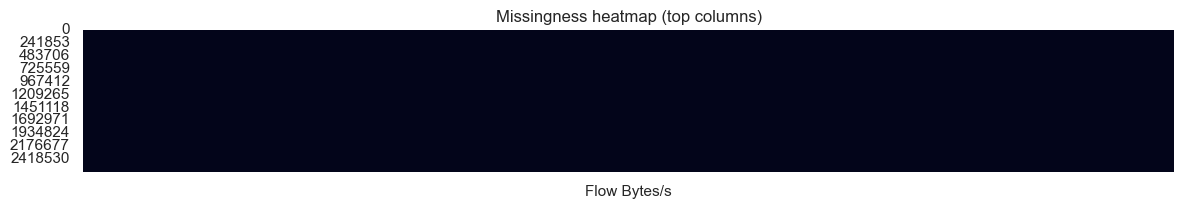

In [ ]:
# 3) Missingness heatmap (top 40 cols by missingness)
top_missing = missing_df[missing_df['missing']>0].head(40).index.tolist()
if len(top_missing):
    plt.figure(figsize=(12, min(8, len(top_missing)*0.25+2)))
    sns.heatmap(df_all[top_missing].isnull(), cbar=False)
    plt.title('Missingness heatmap (top columns)')
    plt.tight_layout()
    plt.savefig('outputs/missingness_heatmap.png')
    plt.show()
else:
    print('No missing values to display.')


In [ ]:
# 4) Protocol / port / IP summaries (best-effort for common column names)
def try_count_plot(col_candidates, title, fname, top_n=10):
    for c in col_candidates:
        if c in df_all.columns:
            vc = df_all[c].value_counts().head(top_n)
            plt.figure(figsize=(8,4))
            sns.barplot(x=vc.values, y=vc.index.astype(str), palette='rocket')
            plt.title(title + f' (column: {c})')
            plt.xlabel('Count')
            plt.tight_layout()
            plt.savefig(f'outputs/{fname}_{c}.png')
            plt.show()
            return
    print('None of', col_candidates, 'found in DataFrame.')

# common protocol column names
try_count_plot(['Protocol','protocol','PROTOCOL','proto'], 'Top Protocols', 'top_protocols')
# common ports
try_count_plot(['Dst Port','dst_port','dport','DstPort','DstPortNumber','destination_port'], 'Top Destination Ports', 'top_dports')
try_count_plot(['Src Port','src_port','sport','SrcPort','source_port'], 'Top Source Ports', 'top_sports')
# top IPs
try_count_plot(['Source IP','Src IP','src_ip','source_ip','SrcIP'], 'Top Source IPs', 'top_src_ips')
try_count_plot(['Destination IP','Dst IP','dst_ip','destination_ip','DstIP'], 'Top Destination IPs', 'top_dst_ips')


None of ['Protocol', 'protocol', 'PROTOCOL', 'proto'] found in DataFrame.
None of ['Dst Port', 'dst_port', 'dport', 'DstPort', 'DstPortNumber', 'destination_port'] found in DataFrame.
None of ['Src Port', 'src_port', 'sport', 'SrcPort', 'source_port'] found in DataFrame.
None of ['Source IP', 'Src IP', 'src_ip', 'source_ip', 'SrcIP'] found in DataFrame.
None of ['Destination IP', 'Dst IP', 'dst_ip', 'destination_ip', 'DstIP'] found in DataFrame.


Numeric distribution candidate columns: [' Flow Duration', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean']


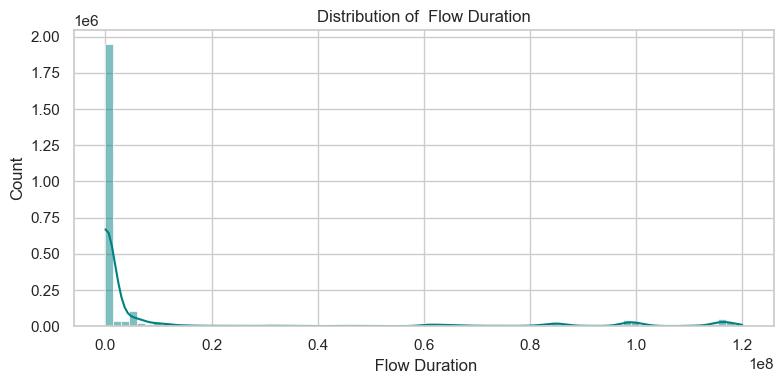

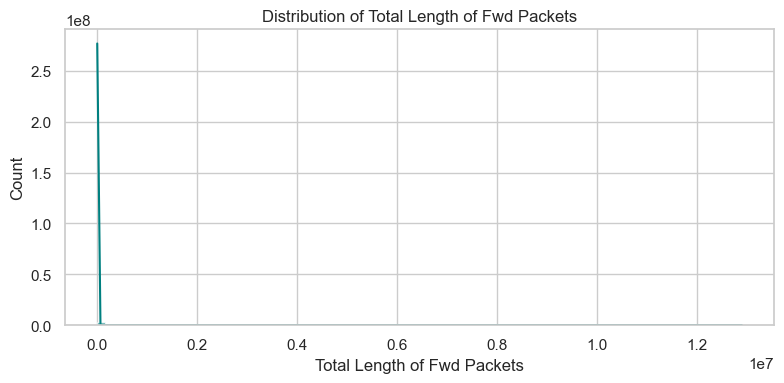

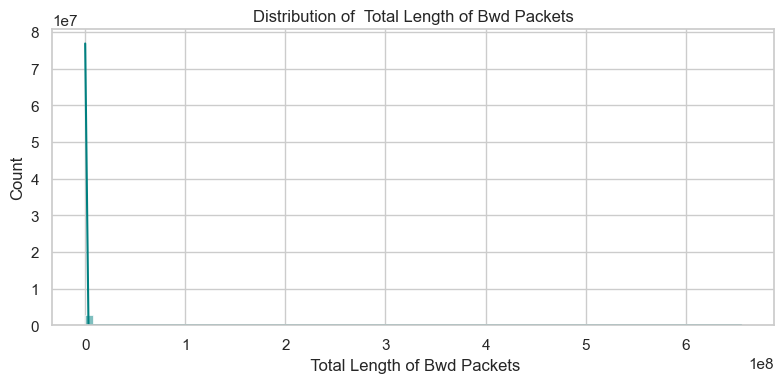

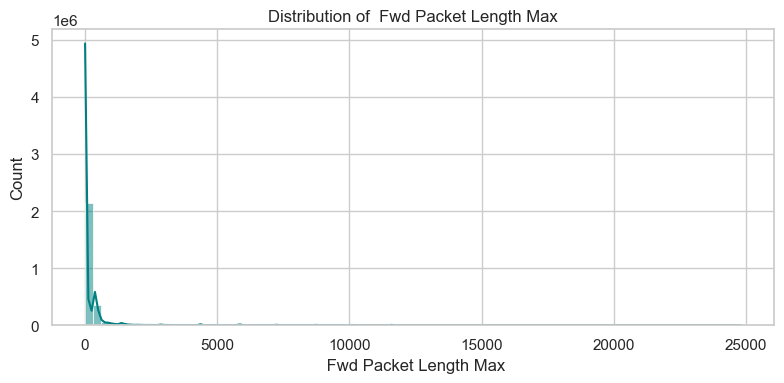

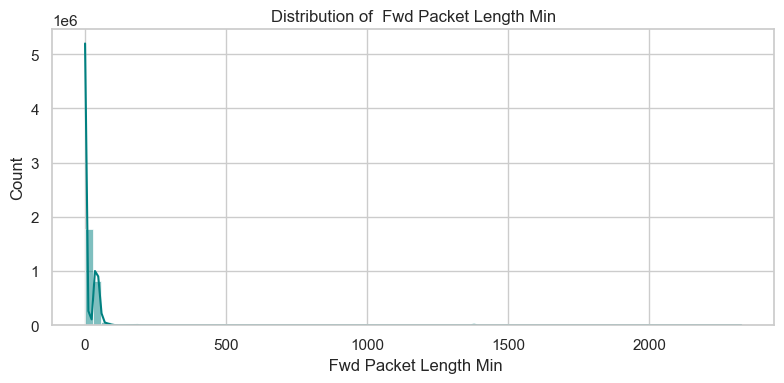

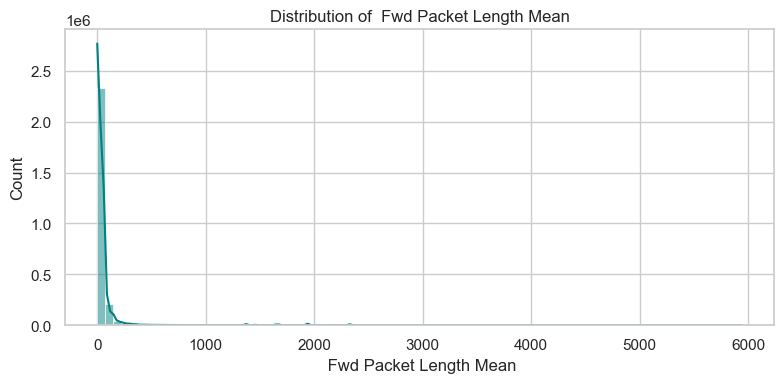

In [ ]:
# 5) Numeric distributions (packet lengths, bytes, durations if present)
candidates = [c for c in df_all.columns if any(k in c.lower() for k in ('len','length','bytes','size','duration','time_ms'))]
print('Numeric distribution candidate columns:', candidates[:10])
for c in candidates[:6]:
    if pd.api.types.is_numeric_dtype(df_all[c]):
        plt.figure(figsize=(8,4))
        sns.histplot(df_all[c].dropna(), bins=80, kde=True, color='teal')
        plt.title(f'Distribution of {c}')
        plt.tight_layout()
        plt.savefig(f'outputs/dist_{c}.png')
        plt.show()


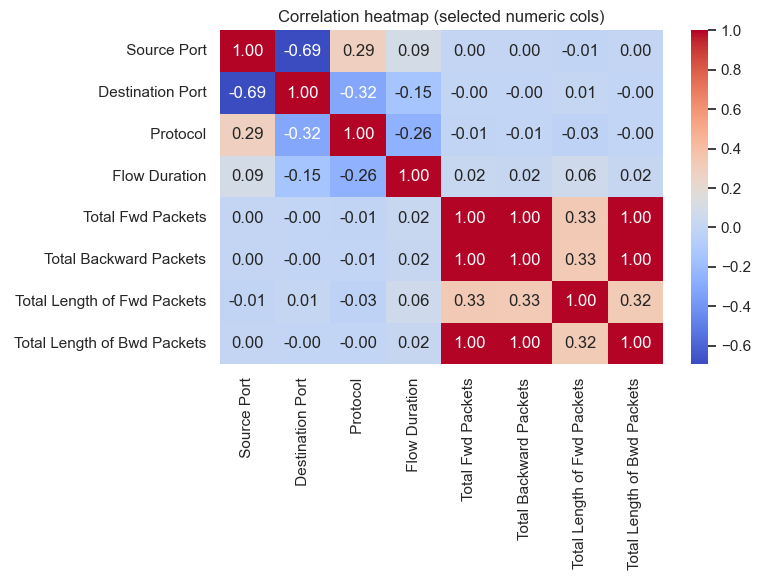

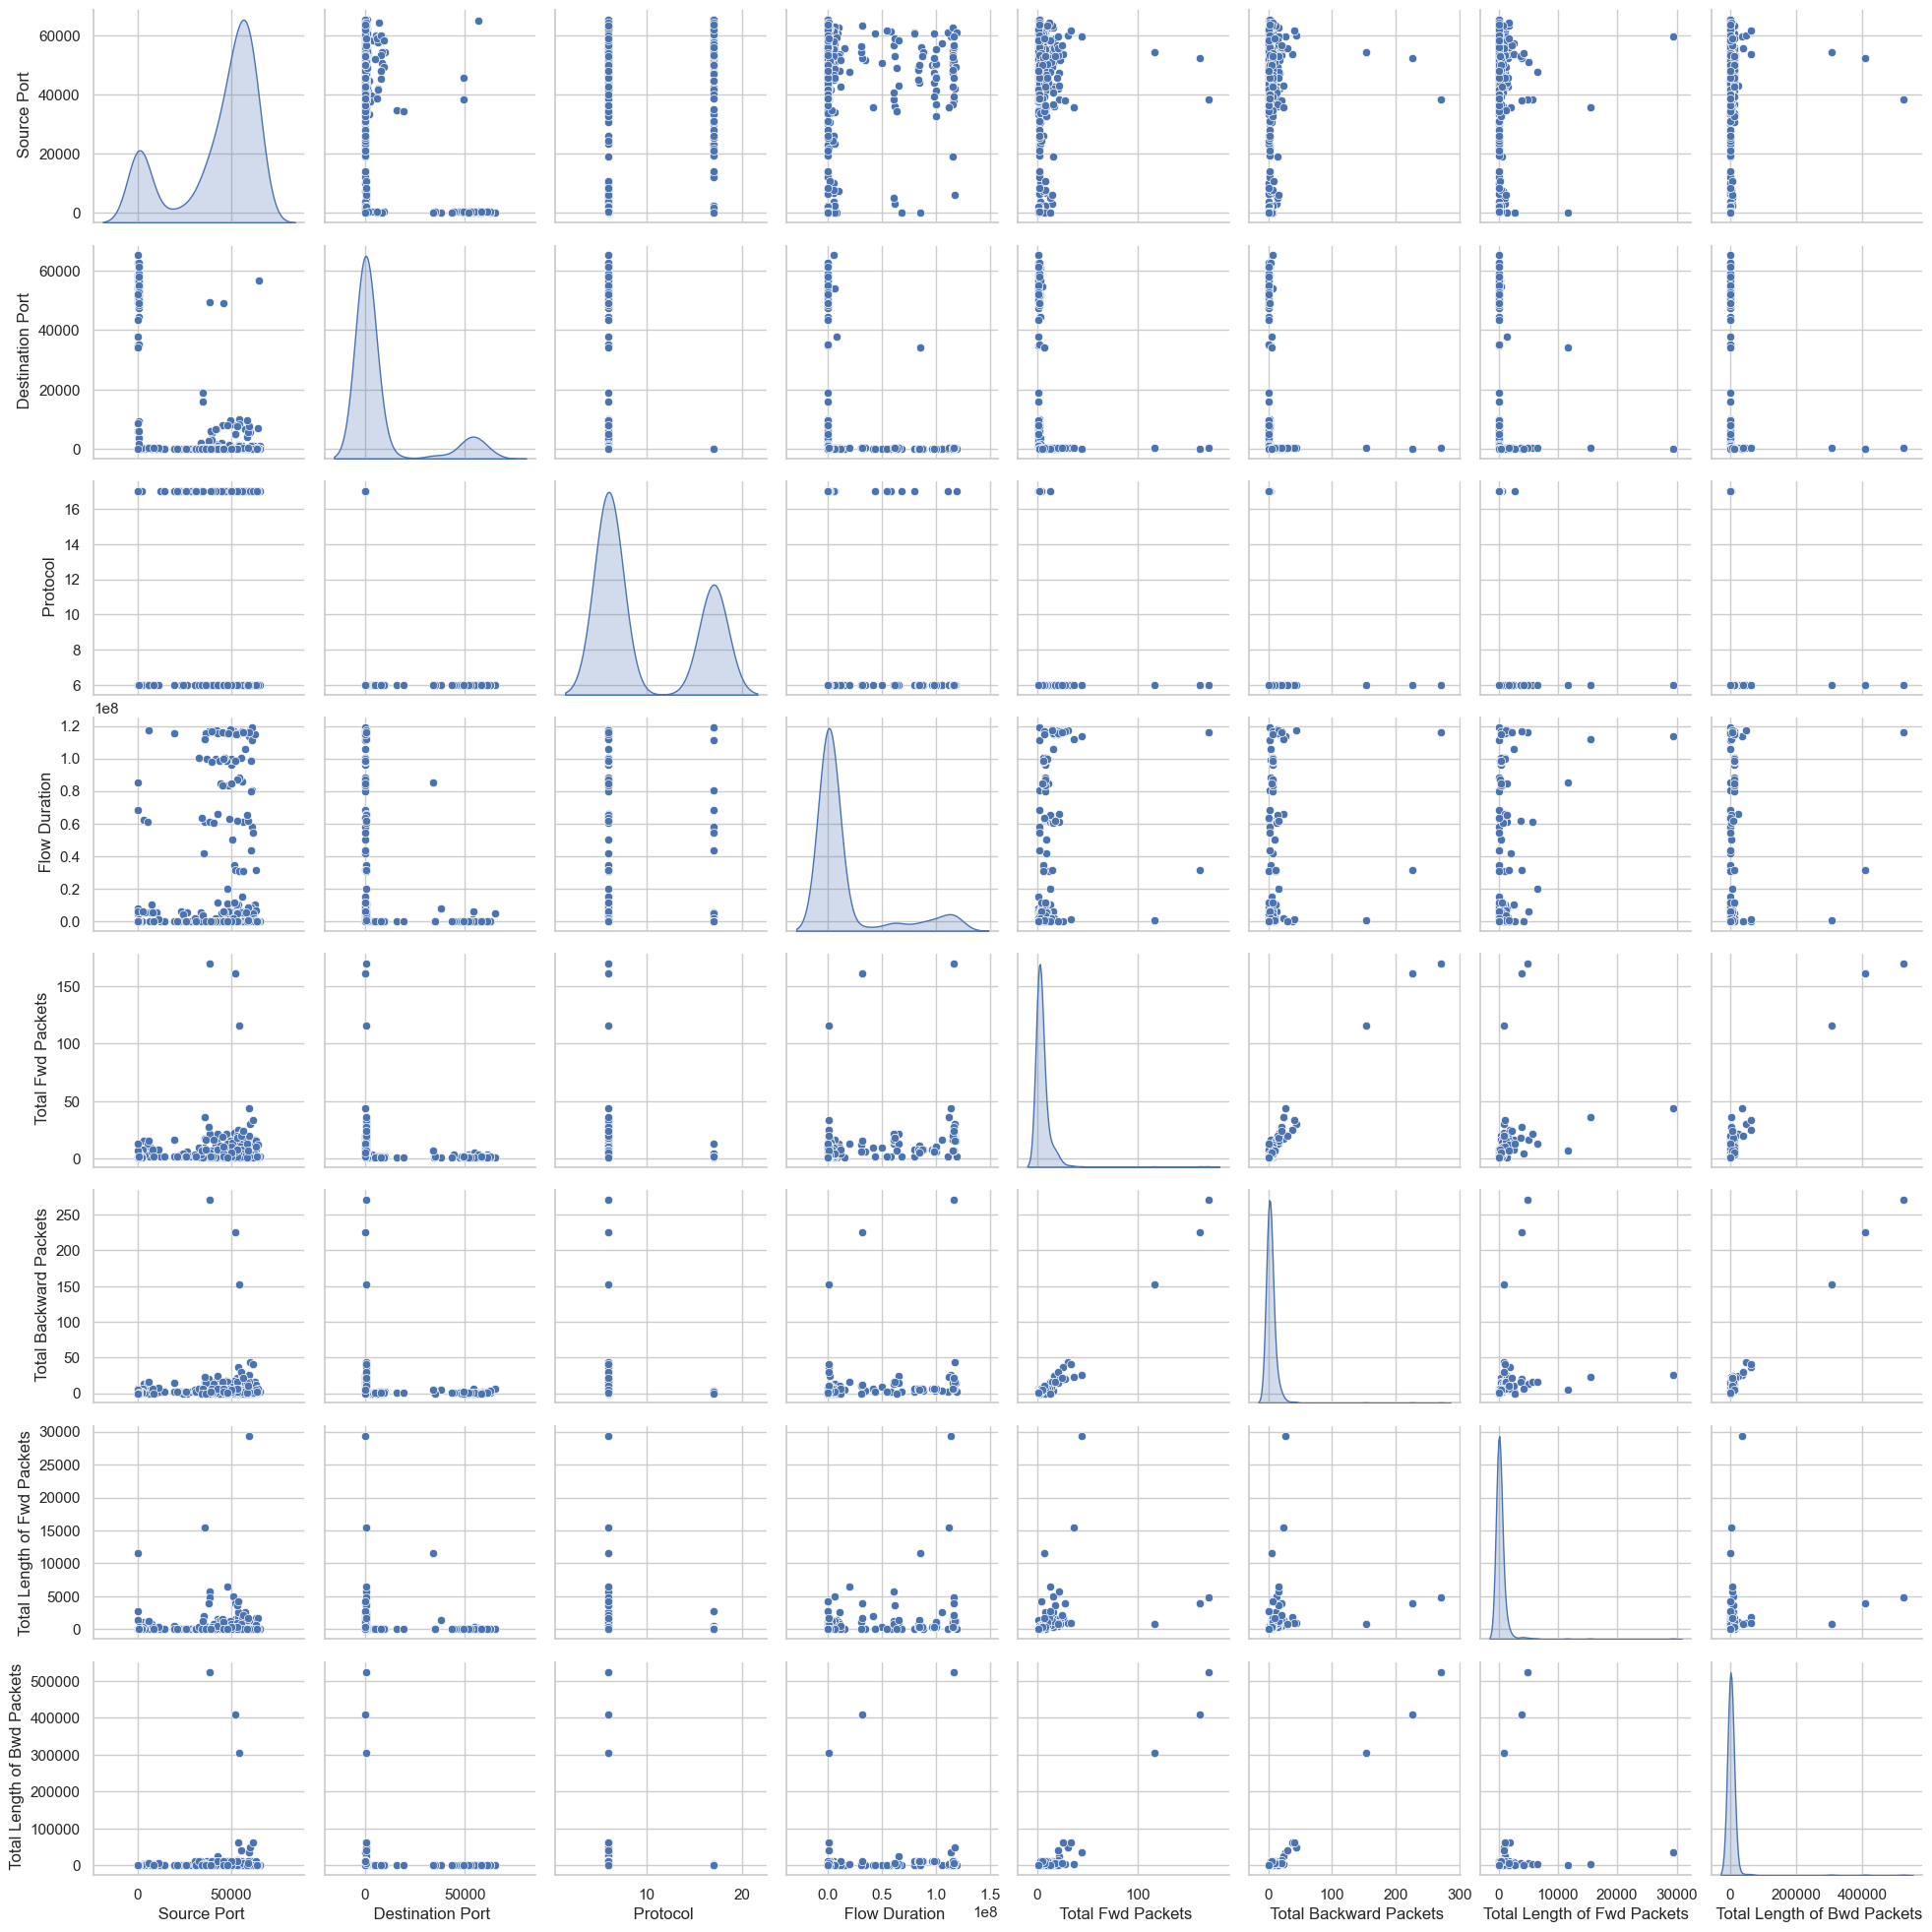

In [ ]:
# 6) Correlation heatmap and pairplot of numeric features (limit size)
num_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    # choose up to 8 numeric columns for pairplot
    cols_for_plots = num_cols[:8]
    corr = df_all[cols_for_plots].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation heatmap (selected numeric cols)')
    plt.tight_layout()
    plt.savefig('outputs/correlation_heatmap.png')
    plt.show()
    try:
        sns.pairplot(df_all[cols_for_plots].dropna().sample(min(500, len(df_all))), diag_kind='kde')
        plt.savefig('outputs/pairplot_numeric.png')
    except Exception as e:
        print('Pairplot failed:', e)
else:
    print('Not enough numeric columns for correlation/pairplot.')


Candidate time columns: [' Timestamp', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Flow Packets/s', 'Fwd Packets/s', ' Bwd Packets/s', ' Fwd Avg Packets/Bulk', ' Bwd Avg Packets/Bulk', 'Subflow Fwd Packets', ' Subflow Bwd Packets']
Using  Timestamp as timestamp


C:\Users\Admin\AppData\Local\Temp\ipykernel_85340\2131577475.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  counts = df_time.resample('1H').size()


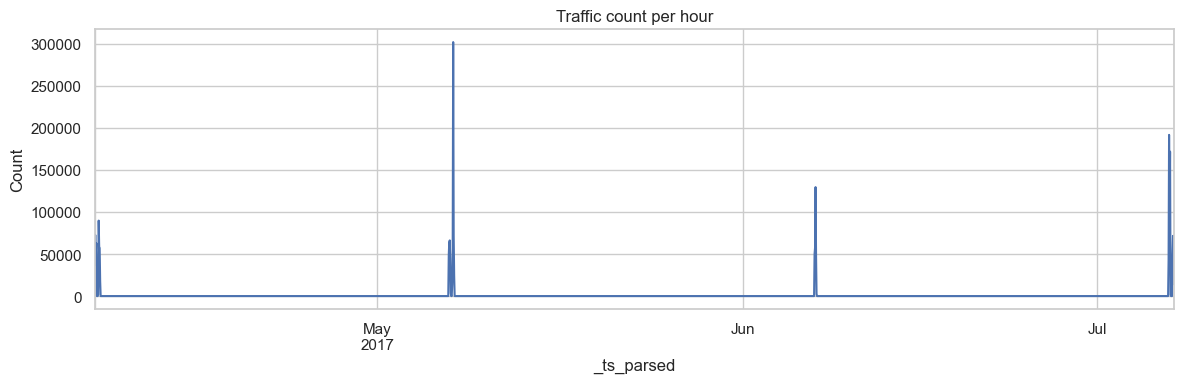

In [ ]:
# 7) Time-series traffic analysis if a timestamp column exists
time_cols = [c for c in df_all.columns if any(k in c.lower() for k in ('time','timestamp','date','ts'))]
print('Candidate time columns:', time_cols)
tcol = None
for c in time_cols:
    try:
        sample = df_all[c].dropna().iloc[0:5]
        pd.to_datetime(sample)
        tcol = c
        break
    except Exception:
        continue

if tcol is not None:
    print('Using', tcol, 'as timestamp')
    df_all['_ts_parsed'] = pd.to_datetime(df_all[tcol], errors='coerce')
    # traffic per hour
    df_time = df_all.dropna(subset=['_ts_parsed']).set_index('_ts_parsed')
    counts = df_time.resample('1H').size()
    plt.figure(figsize=(12,4))
    counts.plot()
    plt.title('Traffic count per hour')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('outputs/traffic_per_hour.png')
    plt.show()
else:
    print('No parsable timestamp column detected; skipping time-series analysis.')


In [ ]:
# 8) Insights summary (print a concise set of findings)
insights = []
# Example automated insights based on checks
if missing_df['percent'].max() > 0:
    insights.append(f'Columns with missing values: {missing_df[missing_df['percent']>0].shape[0]} (see outputs/missingness_heatmap.png)')
else:
    insights.append('No missing values detected.')

if label_cols:
    insights.append(f'Potential label columns: {label_cols}. Check distributions in outputs.')
else:
    insights.append('No clear label column; target labeling may be external.')

if len(num_cols) >= 1:
    insights.append(f'{len(num_cols)} numeric columns found. Correlation and pairplots saved.')

if tcol:
    insights.append(f'Time-series analysis performed on {tcol}.')

print('\nEDA Insights:')
for s in insights:
    print('- ', s)

print('\nSaved all figures to the outputs/ directory.')


SyntaxError: f-string: unmatched '[' (1231335679.py, line 5)